In [107]:
# Import utils
import numpy as np
import pandas as pd
import math
import time
import json
import pyreadr
import pickle
from joblib import dump, load
import os
import copy
import datetime


# Import Gurobi
import gurobipy as gp
from gurobipy import GRB

# Optimization

In [80]:
n_patients = 10
n_samples = 10000
c_w = 1
c_l = 2
T = 8 * 60

In [81]:
z = np.array([np.array([100 for s in range(n_samples)]) for i in range(n_patients)])

In [82]:
# Model
m = gp.Model()

In [83]:
# Primary decision variable
x = m.addVars(n_patients, vtype='I', lb=0, name='x')

# Auxiary decision variable (waiting time)
w = m.addVars(n_patients, n_samples, vtype='I', lb=0, name='w')        

# Auxiary decision variable (overtime)
l = m.addVars(n_samples, vtype='I', lb=0, name='l') 

In [84]:
# Constraints
C1 = m.addConstrs(
    
    w[i,s] + z[i,s] - x[i] <= w[i+1,s]
    
    for i in range(n_patients-1)
    for s in range(n_samples)

)  

C2 = m.addConstrs(
    
    w[n_patients-1,s] + z[n_patients-1,s] + x[n_patients-1] <= l[s]
    
    for s in range(n_samples)

)    

C3 = m.addConstr(
    
    gp.quicksum(x[i] for i in range(n_patients)) <= T

)    

In [85]:
# Objective 
OBJ = m.setObjective(

    # Weighted sum
    gp.quicksum(
        
        1/n_samples * (                                         

            # Waiting time
            c_w * gp.quicksum(w[i,s] for i in range(1, n_patients)) + 

            # Overtime
            c_l * l[s]


        ) for s in range(n_samples)),        

    # min
    GRB.MINIMIZE
)

In [86]:
# Optimize
m.optimize()          

Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: AMD EPYC 7713P 64-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads

Optimize a model with 100001 rows, 110010 columns and 300010 nonzeros
Model fingerprint: 0x0bf2d367
Variable types: 0 continuous, 110010 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-04, 2e-04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 5e+02]
Presolve removed 99992 rows and 109993 columns
Presolve time: 0.20s
Presolved: 9 rows, 17 columns, 33 nonzeros
Variable types: 0 continuous, 17 integer (0 binary)
Found heuristic solution: objective 3599.0000000

Root relaxation: objective 2.140000e+03, 12 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0  

In [87]:
m

<gurobi.Model MIP instance Unnamed: 100001 constrs, 110010 vars, Parameter changes: Username=(user-defined)>

In [90]:
# Results
v_opt = m.objVal
x_hats = [var.xn for var in m.getVars() if 'x' in var.VarName]

In [91]:
x_hats

[100.0, 100.0, 100.0, 100.0, 80.0, -0.0, -0.0, -0.0, -0.0, -0.0]

In [ ]:
## How to use wSAA? 

"""

Each patient's scenario has a different weight, i.e., we need to 'multiply' over patients in "AND" logic ...

However, would we then need the actual permutation of all possible patient-scenarios?

In the paper they 'draw' from the joint distribution ...

"""

# Preprocessing

In [99]:
data = pd.read_csv('/home/fesc/dddex/PatientScheduling/Data/dataHCScheduling.csv')
data.head(5)

,Unnamed: 0,Datum,patient_id,Dauer,Alter,Geschlecht,Notfall,Aufenthalt,ASA,Bereich_Bronchoskopie,...,ÖGD180,ÖGD190,ÖGD200,ÖGD210,ÖGD220,ÖGD230,ÖGD240,ÖGD250,KOLO150,KW
0,0,01.01.19,0,64.0,70,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,1.0
1,1,01.01.19,1,27.0,26,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1.0
2,2,01.01.19,2,13.0,82,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1.0
3,3,01.01.19,3,19.0,67,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1.0
4,4,01.01.19,4,9.0,79,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1.0


In [95]:
data.groupby(['Datum']).agg({'patient_id': len}).reset_index()

,Datum,patient_id
0,01.01.19,63
1,01.02.19,31
2,01.03.19,32
3,01.04.19,36
4,01.06.19,1
...,...,...
313,31.03.19,2
314,31.05.19,17
315,31.07.19,34
316,31.08.19,2


In [142]:
treatments = [
    
    'Bereich_Bronchoskopie', # bronchoscopy
    'Bereich_ERCP',          # endoscopic retrograde cholangiopancreatography
    'Bereich_Endosonographie', # endosonography
    'Bereich_Gastroskopie', # gastroscopy
    'Bereich_Koloskopie' # colonoscopy
    
]

rooms = [

    ['Bereich_Bronchoskopie'],
    ['Bereich_Bronchoskopie', 'Bereich_ERCP', 'Bereich_Gastroskopie', 'Bereich_Koloskopie'],
    ['Bereich_Bronchoskopie', 'Bereich_Endosonographie', 'Bereich_Gastroskopie', 'Bereich_Koloskopie'],
    ['Bereich_Gastroskopie'],
    ['Bereich_Koloskopie']

]

In [217]:
treatment = [treatments[i] for i in np.where(np.array(data[treatments]) == 1)[1]]
data['treatment'] = treatment

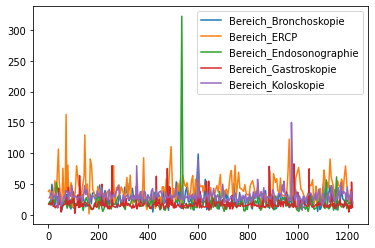

In [223]:
import matplotlib.pyplot as plt
data.groupby(['Datum', 'treatment']).agg({'Dauer': np.mean}).reset_index().groupby('treatment')['Dauer'].plot(legend='True')
plt.show()

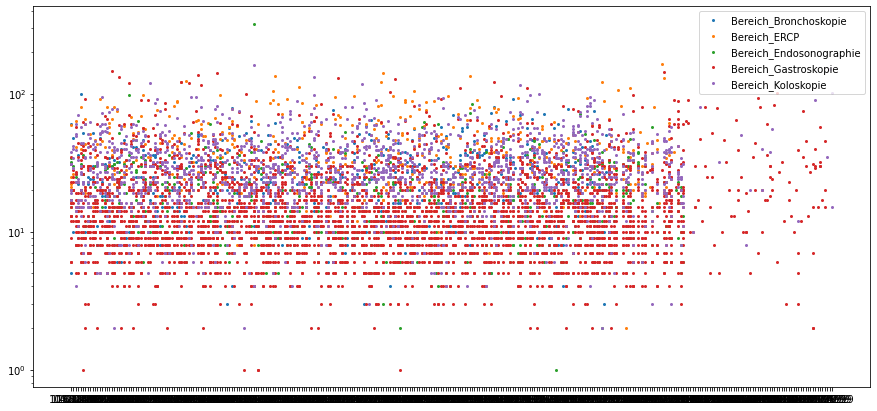

In [216]:
# plot setup
#fig,ax= plt.subplots()
#fig.set_size_inches(15, 7)

groups = data.groupby('treatment')


# Plot
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)

for treatment, group in groups:
    ax.plot(group.Datum, group.Dauer, marker='o', linestyle='', ms=2, label=treatment)
ax.legend()
plt.yscale('log')
plt.show()

In [232]:
summary = data.groupby(['Datum', 'treatment']).agg({
    'patient_id': len,
    'Dauer': np.mean,
}).groupby('treatment').agg({
    'patient_id': np.mean,
    'Dauer': np.mean}).reset_index()
summary

,treatment,patient_id,Dauer
0,Bereich_Bronchoskopie,2.455357,25.733854
1,Bereich_ERCP,2.290179,42.021227
2,Bereich_Endosonographie,2.739130,20.407522
3,Bereich_Gastroskopie,12.961415,19.147167
4,Bereich_Koloskopie,6.660156,31.334181


In [234]:
summary.patient_id * summary.Dauer / 60

0    1.053097
1    1.603935
2    0.931648
3    4.136240
4    3.478176
dtype: float64

## Random Room and Sequence assignment

## Adding setup and wrap-up time

In [236]:
preSurgeryTime = 15
postSurgeryTime = 30

In [237]:
data['duration'] = preSurgeryTime + data.Dauer + postSurgeryTime

In [238]:
# What is the total working time?

In [239]:
# What are the features / columns in the data (apart from the obvious ones)

In [102]:
def getRoomData():

    roomData = pd.DataFrame([[[0]],            # Raum: Bronchoskopie    # Behandlungstypen: Bronchoskopie
                             [[0, 1, 3, 4]],   # Raum: ERCP             # Behandlungstypen: alles außer Endosonographie
                             [[0, 2, 3, 4]],   # Raum: Endosonographie  # Behandlungstypen: alles außer ERCP
                             [[3]],            # Raum: Gastroskopie     # Behandlungstypen: Gastroskopie
                             [[4]]],           # Raum: Koloskopie       # Behandlungstypen: Koloskopie
                            columns = ['type'])
    
    return roomData

In [103]:
rooms = getRoomData()

In [104]:
rooms

,type
0,[0]
1,"[0, 1, 3, 4]"
2,"[0, 2, 3, 4]"
3,[3]
4,[4]


In [141]:
def getTreatmentData(dataTest, date):

    treatmentCols = np.array(['Bereich_Bronchoskopie', 
                              'Bereich_ERCP', 
                              'Bereich_Endosonographie', 
                              'Bereich_Gastroskopie', 
                              'Bereich_Koloskopie'])

    booleanDay = dataTest['Datum'] == date
    dataTestDay = dataTest[booleanDay]

    treatmentSeries = dataTestDay[treatmentCols].idxmax(axis = 1)
    treatmentsAsNumbers = [np.where(treatmentCols == treatmentSeries[i])[0][0] for i in treatmentSeries.index]

    treatmentData = pd.DataFrame({'patient_id': dataTestDay['patient_id'], 'type': treatmentsAsNumbers}).set_index('patient_id')

    return treatmentData

0       0
1       0
2       0
3       0
4       0
       ..
7361    0
7362    0
7363    0
7364    0
7365    0
Name: Bereich_Bronchoskopie, Length: 7366, dtype: int64

In [112]:
data['Datum']

0       01.01.19
1       01.01.19
2       01.01.19
3       01.01.19
4       01.01.19
          ...   
7361    27.12.19
7362    28.12.19
7363    29.12.19
7364    29.12.19
7365    29.12.19
Name: Datum, Length: 7366, dtype: object

In [110]:
date = datetime.date(year=2019, month=12, day=1)

In [113]:
date.weekday()

6

In [131]:
date = [int(i) for i in reversed(data['Datum'].iloc[0].split('.'))]

In [133]:
date = datetime.date(year=date[0], month=date[1], day=date[2])

In [ ]:
def getSingleScenario(scenarioIndex, distributionDictDay):
    
    patientsOfDay = distributionDictDay.keys()
    
    randomProbsDict = {ID: uniform(size = 1) for ID in patientsOfDay}    
    sample = [distributionDictDay[ID][1][np.where(distributionDictDay[ID][0] >= randomProbsDict[ID])[0][0]] for ID in patientsOfDay]
    
    scenarioIndices = np.repeat(scenarioIndex, len(patientsOfDay))
    
    scenarioData = pd.DataFrame([patientsOfDay, scenarioIndices, sample]).transpose()
    scenarioData.columns = ['patient_id', 'scenario', 'duration']

    return scenarioData    

In [ ]:
def getScenariosPerDay(YTrain, dataTest, weightsDataDict, nScenarios):
    
    patientIDs = weightsDataDict.keys()
    distributionDict = {patientId: 
                        getDistributionOfPatient(YTrain = YTrain, 
                                                 weights = weightsDataDict[patientId][0], 
                                                 indicesPosWeight = weightsDataDict[patientId][1])
                        for patientId in patientIDs}
    
    #---
    
    dates = dataTest['Datum'].unique()
    scenariosPerDayDict = dict()
    
    for date in dates:
    
        dataTestDay = dataTest[dataTest['Datum'] == date]
        patientsOfDay = dataTestDay['patient_id']
        distributionDictDay = {patient_id: distributionDict[patient_id] for patient_id in patientsOfDay}
        
        scenarioData = [getSingleScenario(scenarioIndex, distributionDictDay) for scenarioIndex in np.arange(nScenarios)]
        scenarioDf = pd.concat(scenarioData, axis = 0).set_index(['patient_id', 'scenario'])
        
        scenariosPerDayDict[date] = scenarioDf
        
    return scenariosPerDayDict